# Kaggle Energy — Event Validation Notebook

This notebook helps you:
1) **Run** the detector on `data/kaggle/train.csv`  
2) **Validate** predicted *events* against Kaggle point labels (`anomaly`)  
3) **Visualize** actual vs expected with predicted events overlaid

> Tip: Start with a small subset (few buildings / time window) so plots and metrics run fast.


In [1]:
import pandas as pd

from anomlib.datasets.kaggle_energy.load import load_train
from anomlib.detectors import EnergyTimeSeriesDetector, GenericTimeSeriesDetector
from anomlib.core.schema import normalize_timeseries_df

# Load full dataset
df = load_train("../data/kaggle/train.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.dropna(subset=["meter_reading"]).reset_index(drop=True)

# Load event overlap table (generated by kaggle_train_eval.py)
evt = pd.read_csv("../out/kaggle_events_with_overlap.csv", parse_dates=["start", "end"])

print("Total events:", len(evt))
evt.head()


Total events: 1625


,event_idx,entity_id,start,end,n_points,label_frac,direction,severity,score_peak,score_mean,reason
0,0,1,2016-11-17 10:00:00,2016-11-24 11:00:00,169,0.017751,both,19.964445,19.964445,12.315884,both deviation beyond 3.5 (end_ratio=0.6)
1,1,1,2016-11-24 18:00:00,2016-11-29 09:00:00,112,0.000000,both,18.610645,18.610645,9.786289,both deviation beyond 3.5 (end_ratio=0.6)
2,2,1,2016-12-01 18:00:00,2016-12-04 11:00:00,66,0.000000,both,18.232730,18.232730,12.002380,both deviation beyond 3.5 (end_ratio=0.6)
3,3,1,2016-12-04 19:00:00,2016-12-05 08:00:00,14,0.000000,both,8.475619,8.475619,7.123065,both deviation beyond 3.5 (end_ratio=0.6)
4,4,1,2016-12-06 23:00:00,2016-12-12 08:00:00,130,0.015385,both,18.486989,18.486989,11.514892,both deviation beyond 3.5 (end_ratio=0.6)


In [3]:
# Routing controls
AUTO_ROUTE_GENERIC = True
AUTO_ROUTE_TOP_K = 10
MANUAL_GENERIC_BUILDINGS = {1068}  # always routed to generic

energy_det = EnergyTimeSeriesDetector(
    entity_col="building_id",
    time_col="timestamp",
    value_col="meter_reading",
    direction="both",
    threshold=3.5,
    threshold_quantile=0.9995,
    threshold_cap=3.2,
    threshold_end_ratio=0.6,
    min_duration="8h",
    gap_tolerance="1h",
    seasonal_weight=0.35,
    rolling_window=8,
    local_clip_ratio=0.8,
)

generic_det = GenericTimeSeriesDetector(
    entity_col="building_id",
    time_col="timestamp",
    value_col="meter_reading",
    direction="both",
    threshold=3.5,
    threshold_quantile=0.9995,
    threshold_cap=3.5,
    threshold_end_ratio=0.6,
    min_duration="8h",
    gap_tolerance="1h",
)

fit_df = df[df["anomaly"] == 0].copy()

# Auto-route buildings where energy baseline mismatch on normal points is largest.
GENERIC_BUILDINGS = set(MANUAL_GENERIC_BUILDINGS)
auto_routed = []

if AUTO_ROUTE_GENERIC and len(fit_df):
    energy_det.fit(fit_df)

    fit_scored = fit_df.sort_values(["building_id", "timestamp"]).copy()
    fn = normalize_timeseries_df(fit_scored, "building_id", "timestamp", "meter_reading")
    pred = energy_det.baseline.predict(fn)

    fit_scored = fit_scored.reset_index(drop=True)
    fit_scored["expected"] = pred.expected.to_numpy()
    fit_scored["abs_err"] = (fit_scored["meter_reading"] - fit_scored["expected"]).abs()

    mismatch = (
        fit_scored.groupby("building_id")["abs_err"]
        .median()
        .sort_values(ascending=False)
    )
    auto_routed = [int(x) for x in mismatch.head(AUTO_ROUTE_TOP_K).index.tolist()]
    GENERIC_BUILDINGS.update(auto_routed)

fit_energy = fit_df[~fit_df["building_id"].isin(GENERIC_BUILDINGS)]
fit_generic = fit_df[fit_df["building_id"].isin(GENERIC_BUILDINGS)]

if len(fit_energy):
    energy_det.fit(fit_energy)
if len(fit_generic):
    generic_det.fit(fit_generic)

def detector_for_building(building_id: int):
    return generic_det if building_id in GENERIC_BUILDINGS else energy_det

# Back-compat name used in some cells
det = energy_det

print("manual_generic_buildings:", sorted(MANUAL_GENERIC_BUILDINGS))
if AUTO_ROUTE_GENERIC:
    print("auto_route_top_k:", AUTO_ROUTE_TOP_K)
    print("auto_routed_buildings:", auto_routed)
print("generic_buildings(final):", sorted(GENERIC_BUILDINGS))
print("fit rows | energy:", len(fit_energy), "generic:", len(fit_generic))


KeyboardInterrupt: 

## A) Plot Raw Value + Expected + Score + Label

For 3-5 buildings, this plots:
- `meter_reading` (actual)
- baseline `expected`
- labeled anomalies
- detected event windows
- score trace with per-entity thresholds


In [ ]:
import matplotlib.pyplot as plt


def detect_routed(df_in):
    m = df_in["building_id"].isin(GENERIC_BUILDINGS)
    d_energy = df_in.loc[~m]
    d_generic = df_in.loc[m]

    events_all = []
    score_parts = []

    if len(d_energy):
        e_events, e_scores = energy_det.detect(d_energy)
        events_all.extend(e_events)
        score_parts.append(e_scores)

    if len(d_generic):
        g_events, g_scores = generic_det.detect(d_generic)
        events_all.extend(g_events)
        score_parts.append(g_scores)

    score_df = (
        pd.concat(score_parts, axis=0)
        .sort_values(["entity_id", "timestamp"])
        .reset_index(drop=True)
    )
    return events_all, score_df


# Run routed detection on full cleaned frame to get model scores + predicted events
events_all, score_df = detect_routed(df)
pred_evt = pd.DataFrame([
    {
        "entity_id": e.entity_id,
        "start": pd.to_datetime(e.start),
        "end": pd.to_datetime(e.end),
        "direction": e.direction,
        "severity": e.severity,
        "score_peak": e.score_peak,
        "score_mean": e.score_mean,
        "reason": e.reason,
    }
    for e in events_all
])

score_df = score_df.rename(columns={"entity_id": "building_id", "value": "meter_reading_norm"})
diag = df.merge(
    score_df[["building_id", "timestamp", "score"]],
    on=["building_id", "timestamp"],
    how="left",
)

print("Predicted events:", len(pred_evt))
print("Rows with score:", int(diag["score"].notna().sum()))


Predicted events: 5561
Rows with score: 1641841


In [ ]:
from pathlib import Path


def _entity_thresholds(detector, bid):
    thr_start = float(getattr(detector, "threshold", 3.5))
    thr_map = getattr(detector, "_threshold_by_entity", None)
    if isinstance(thr_map, dict):
        v = thr_map.get(bid, thr_map.get(str(bid), None))
        if v is not None:
            thr_start = float(v)
    end_ratio = float(getattr(detector, "threshold_end_ratio", 1.0))
    thr_end = max(0.0, thr_start * end_ratio)
    return thr_start, thr_end


def plot_building_diagnostics(
    detector,
    data,
    event_df,
    building_id,
    window_hours=168,
    save_path=None,
    show=True,
):
    active_detector = detector_for_building(int(building_id))

    g = data[data["building_id"] == building_id].sort_values("timestamp").copy()
    if g.empty:
        print(f"No data for building {building_id}")
        return None

    anom = g[g["anomaly"] == 1]
    center = anom["timestamp"].iloc[0] if len(anom) else g["timestamp"].iloc[len(g) // 2]

    start = center - pd.Timedelta(hours=window_hours // 2)
    end = center + pd.Timedelta(hours=window_hours // 2)
    w = g[(g["timestamp"] >= start) & (g["timestamp"] <= end)].copy()

    wn = normalize_timeseries_df(w, active_detector.entity_col, active_detector.time_col, active_detector.value_col)
    pred = active_detector.baseline.predict(wn)
    w = w.reset_index(drop=True)
    w["expected"] = pred.expected.to_numpy()

    e = event_df[event_df["entity_id"].astype(str) == str(building_id)].copy()
    e = e[(e["start"] <= end) & (e["end"] >= start)]

    thr_start, thr_end = _entity_thresholds(active_detector, building_id)
    direction = getattr(active_detector, "direction", "low")

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(w["timestamp"], w["meter_reading"], label="meter_reading", linewidth=1.2)
    axes[0].plot(w["timestamp"], w["expected"], label="expected", linewidth=1.2)
    lbl = w[w["anomaly"] == 1]
    axes[0].scatter(lbl["timestamp"], lbl["meter_reading"], s=16, label="label=1", zorder=3)

    for _, r in e.iterrows():
        axes[0].axvspan(r["start"], r["end"], alpha=0.18, color="tab:red")

    axes[0].set_ylabel("value")
    axes[0].set_title(f"Building {building_id} | raw + expected + labels + predicted events")
    axes[0].legend(loc="upper right")

    axes[1].plot(w["timestamp"], w["score"], label="score", linewidth=1.1, color="tab:purple")
    if direction == "both":
        axes[1].axhline(thr_start, linestyle="--", color="tab:red", label="start threshold")
        axes[1].axhline(-thr_start, linestyle="--", color="tab:red")
        axes[1].axhline(thr_end, linestyle=":", color="tab:orange", label="continue threshold")
        axes[1].axhline(-thr_end, linestyle=":", color="tab:orange")
    elif direction == "high":
        axes[1].axhline(thr_start, linestyle="--", color="tab:red", label="start threshold")
        axes[1].axhline(thr_end, linestyle=":", color="tab:orange", label="continue threshold")
    else:
        axes[1].axhline(-thr_start, linestyle="--", color="tab:red", label="start threshold")
        axes[1].axhline(-thr_end, linestyle=":", color="tab:orange", label="continue threshold")

    for _, r in e.iterrows():
        axes[1].axvspan(r["start"], r["end"], alpha=0.12, color="tab:red")

    axes[1].set_ylabel("score")
    axes[1].set_xlabel("timestamp")
    axes[1].set_title("score + thresholds")
    axes[1].legend(loc="upper right")

    fig.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=140)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig


Selection mode: most_anomalies
Buildings to plot (20): [1319, 1258, 439, 247, 1225, 1226, 141, 935, 560, 1275, 693, 1001, 290, 159, 108, 1302, 936, 1296, 732, 1068]
[1/20] building 1319


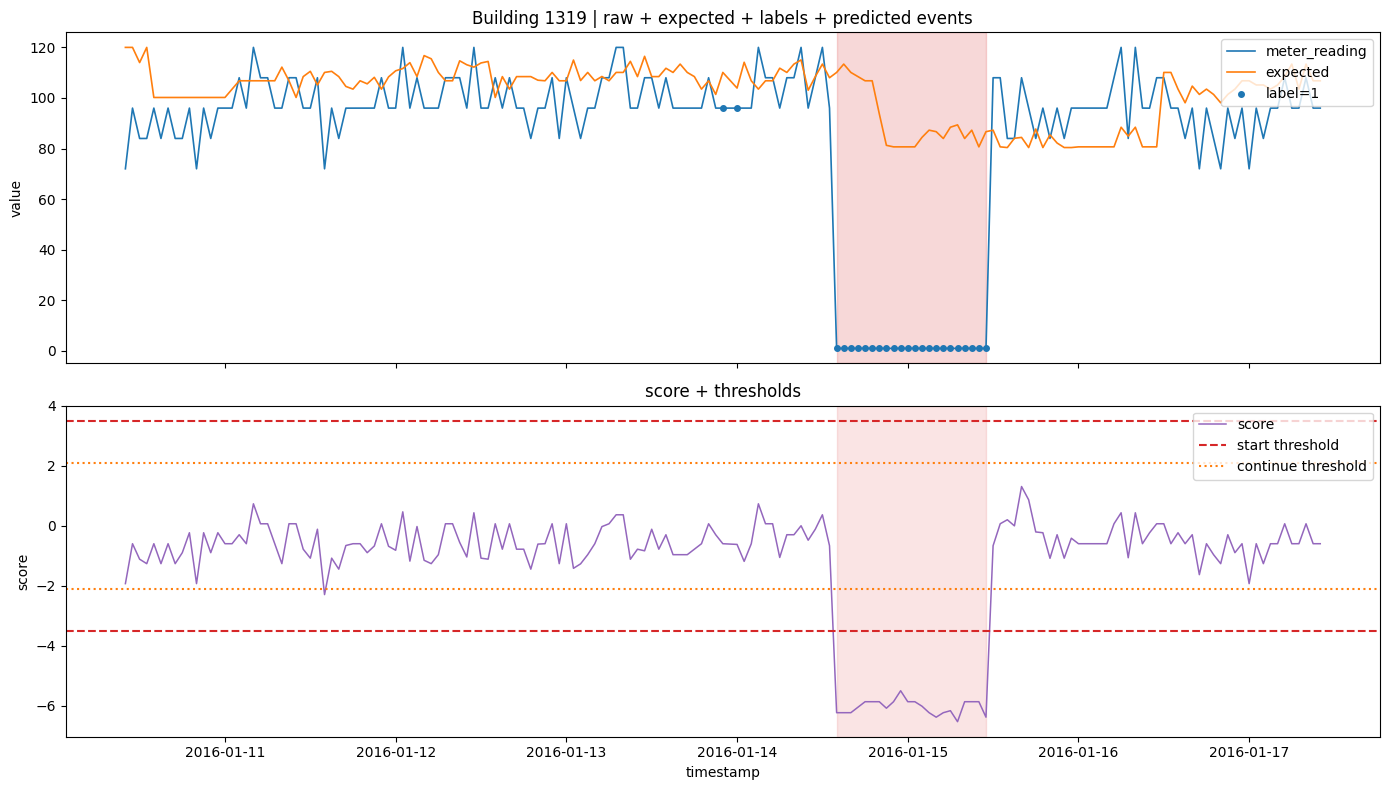

[2/20] building 1258


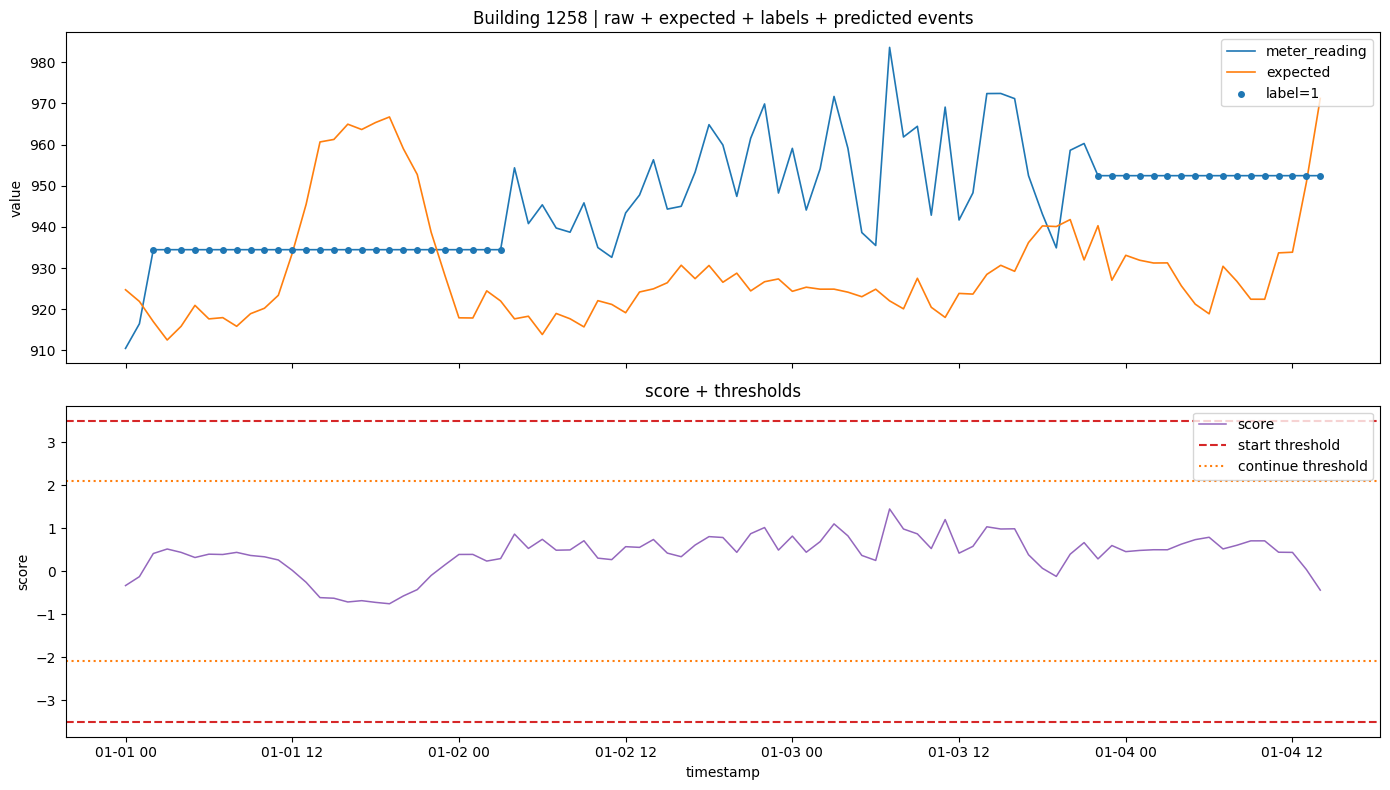

[3/20] building 439


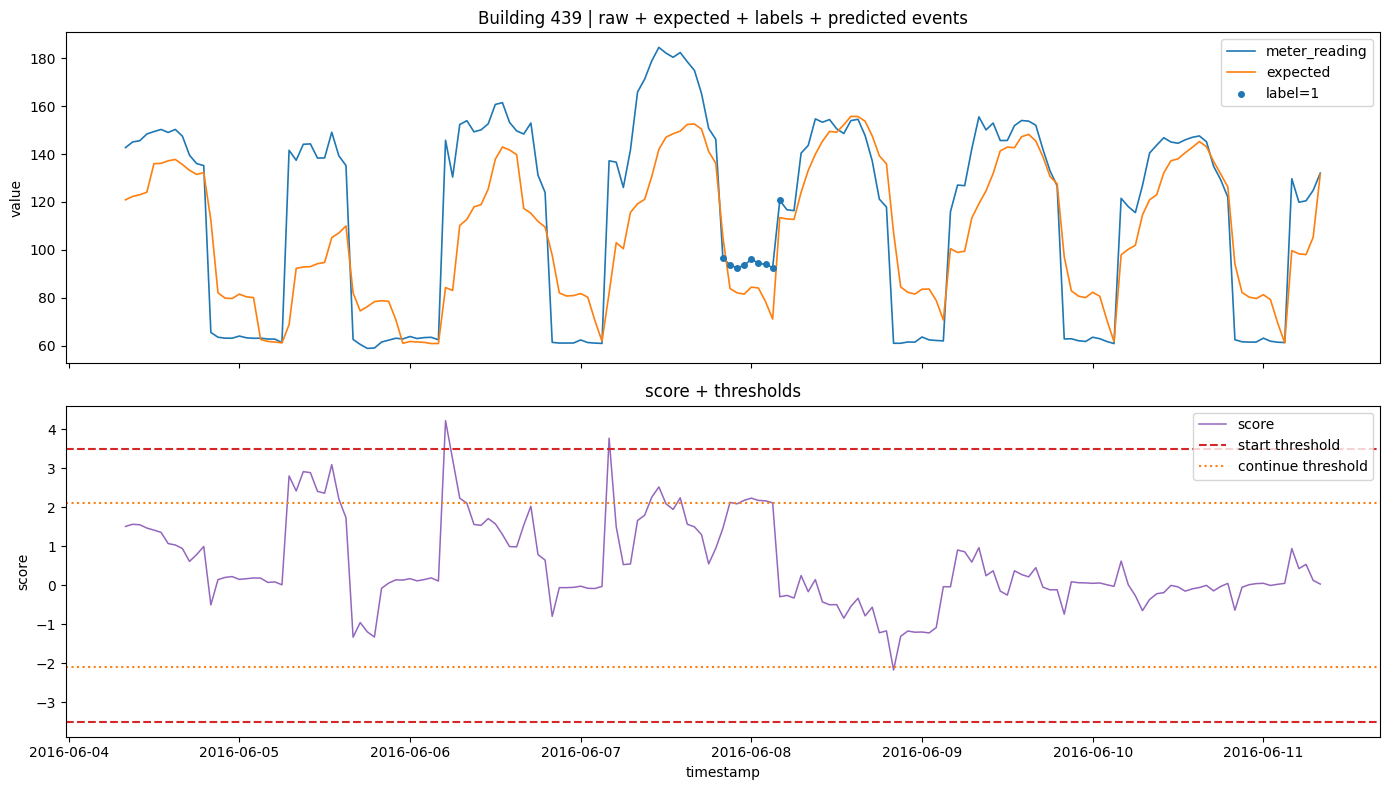

[4/20] building 247


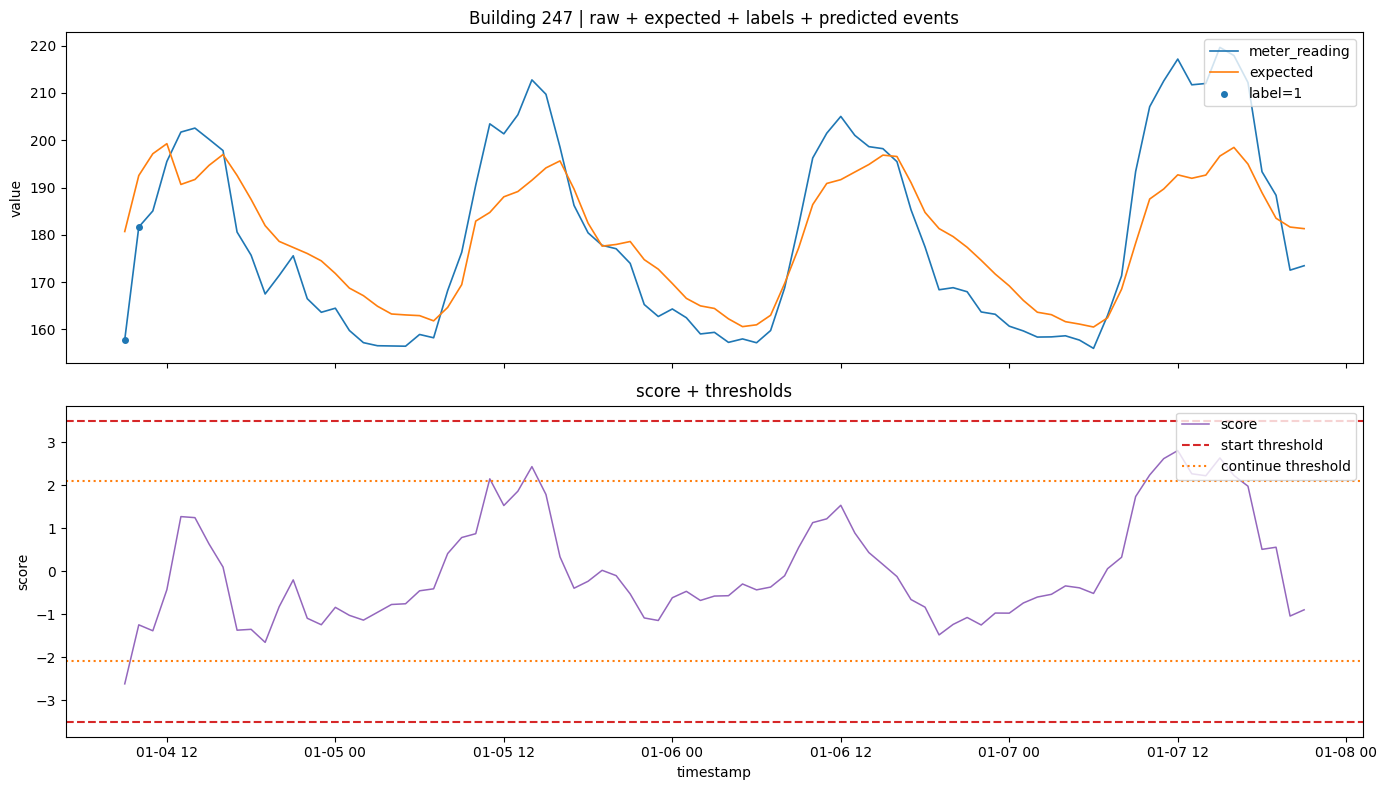

[5/20] building 1225


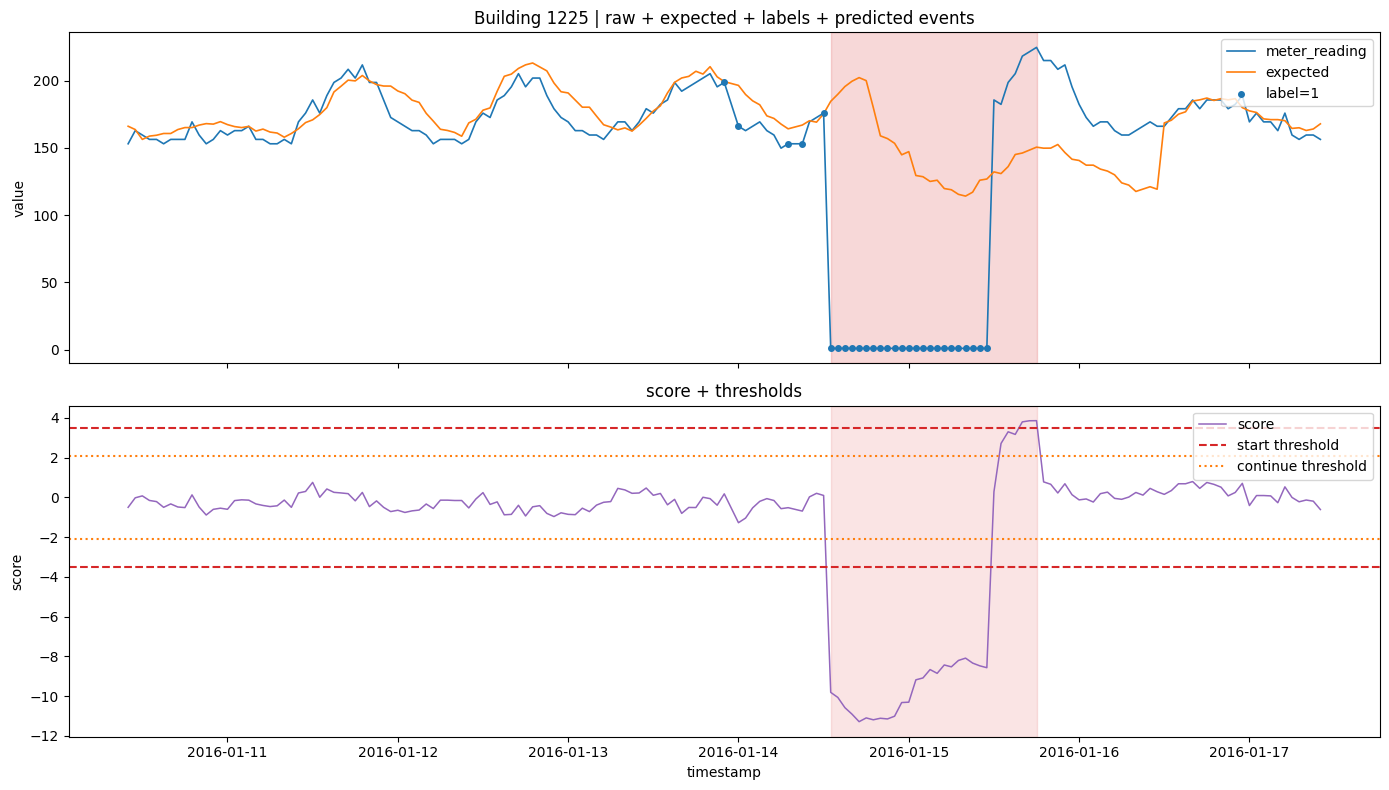

[6/20] building 1226


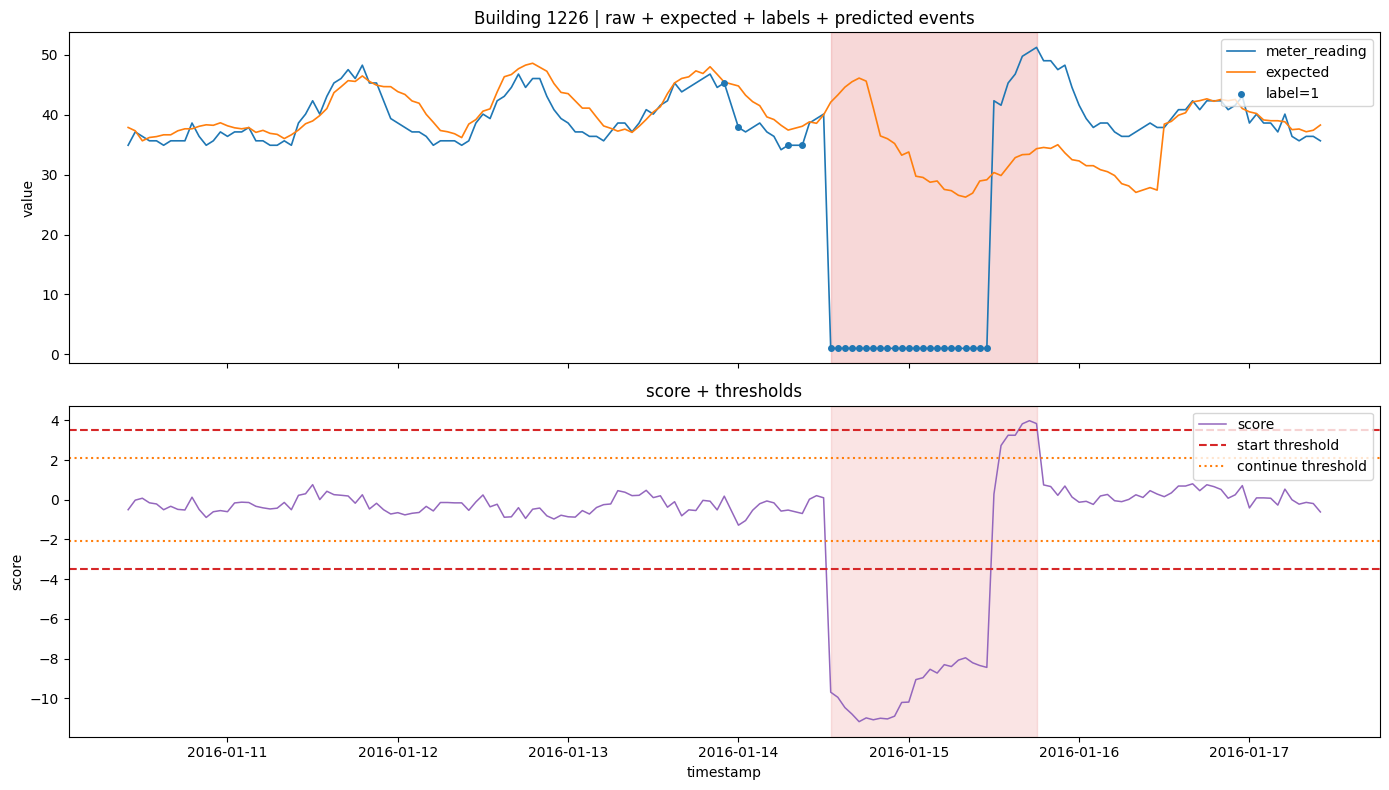

[7/20] building 141


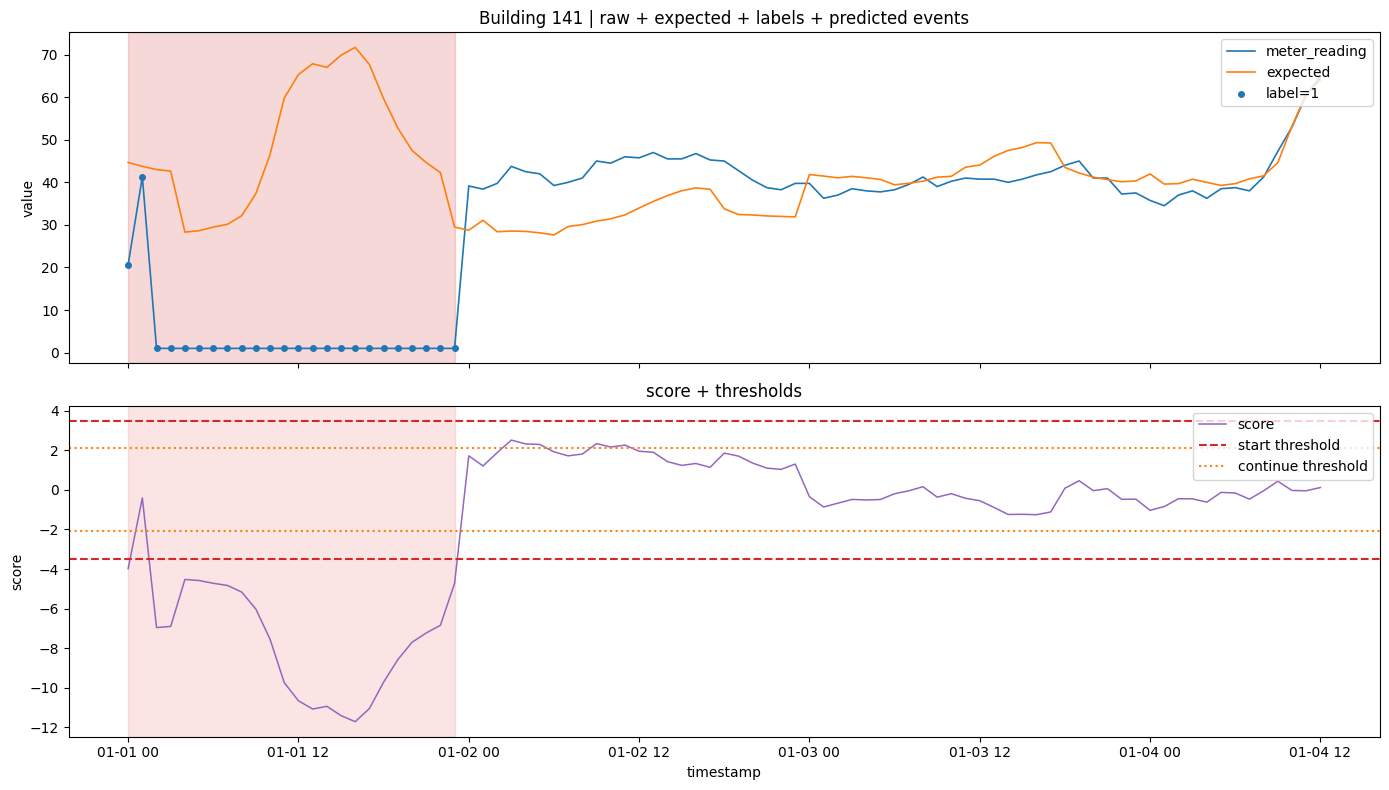

[8/20] building 935


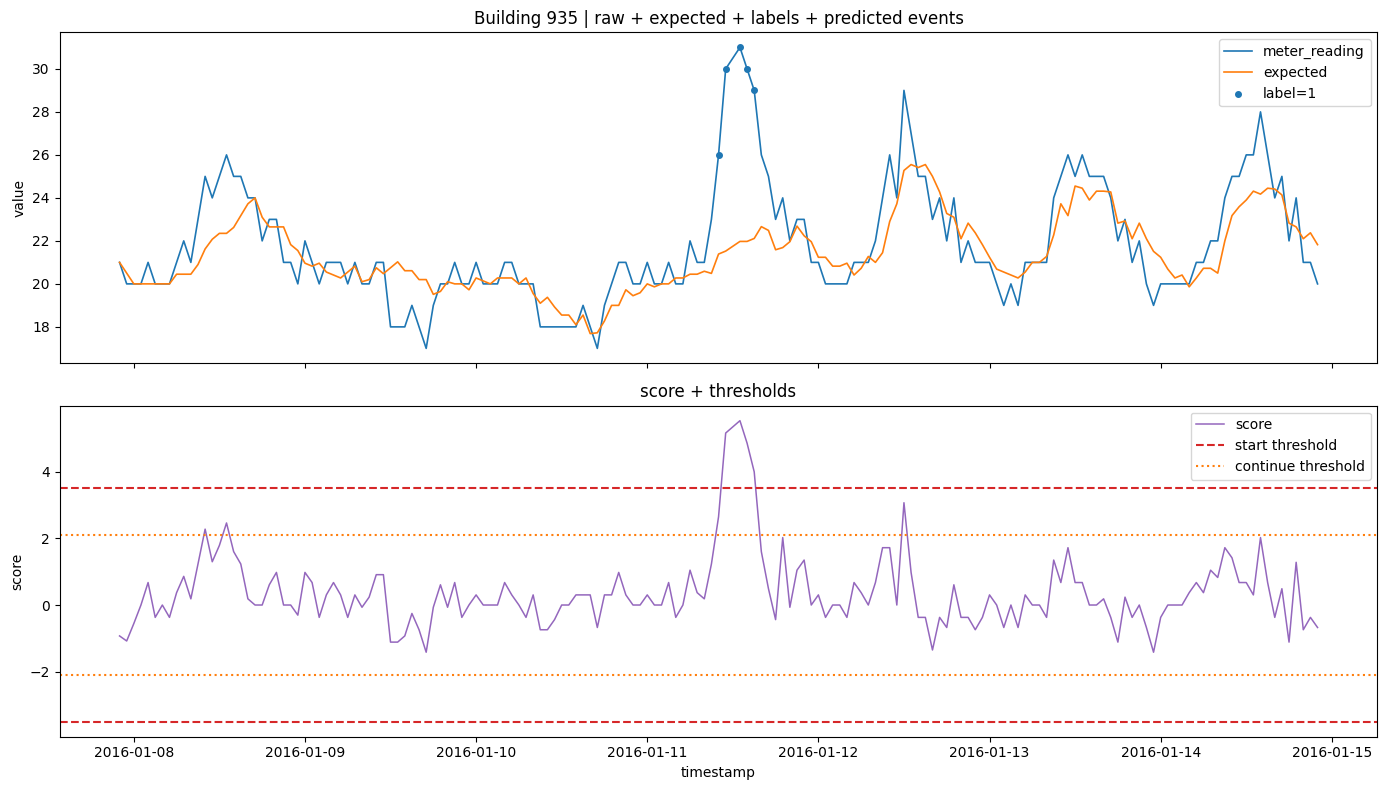

[9/20] building 560


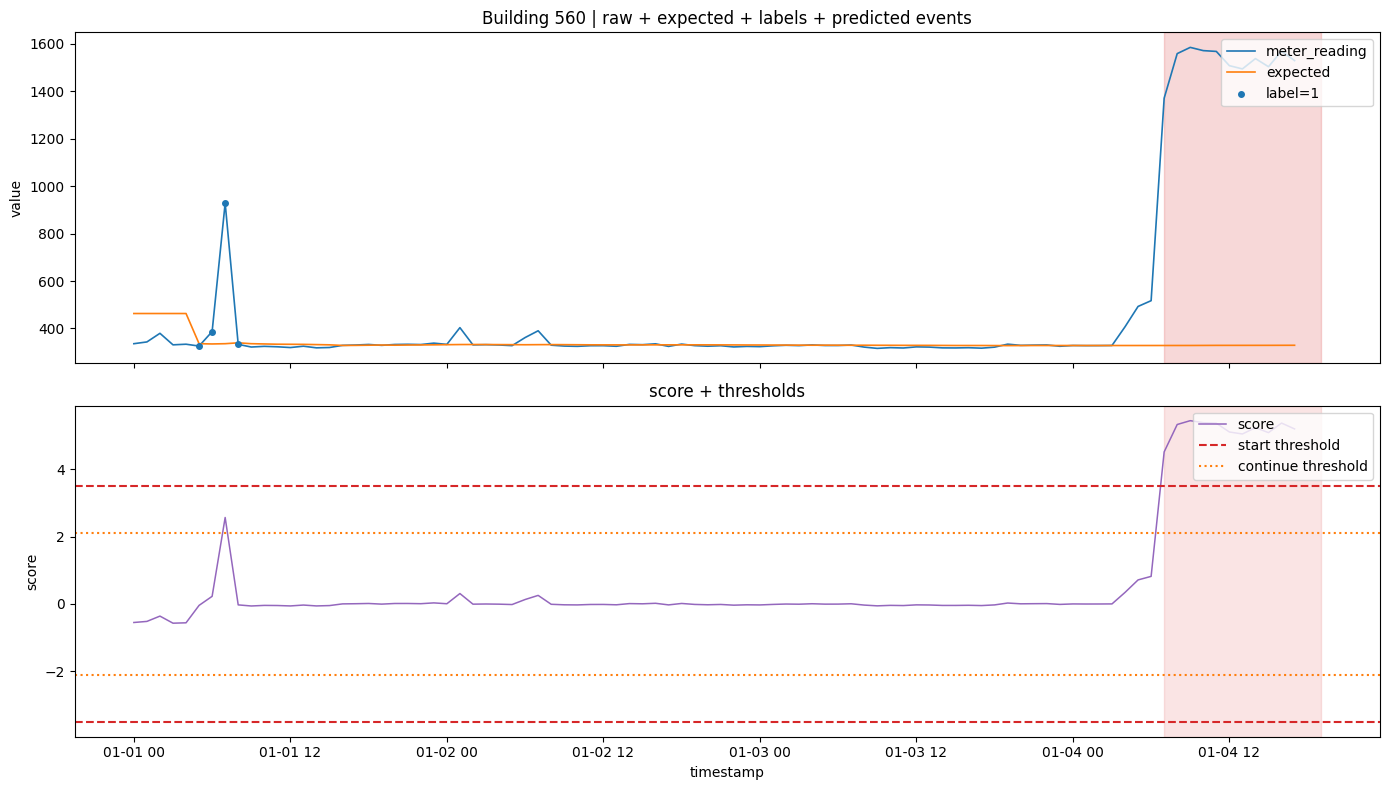

[10/20] building 1275


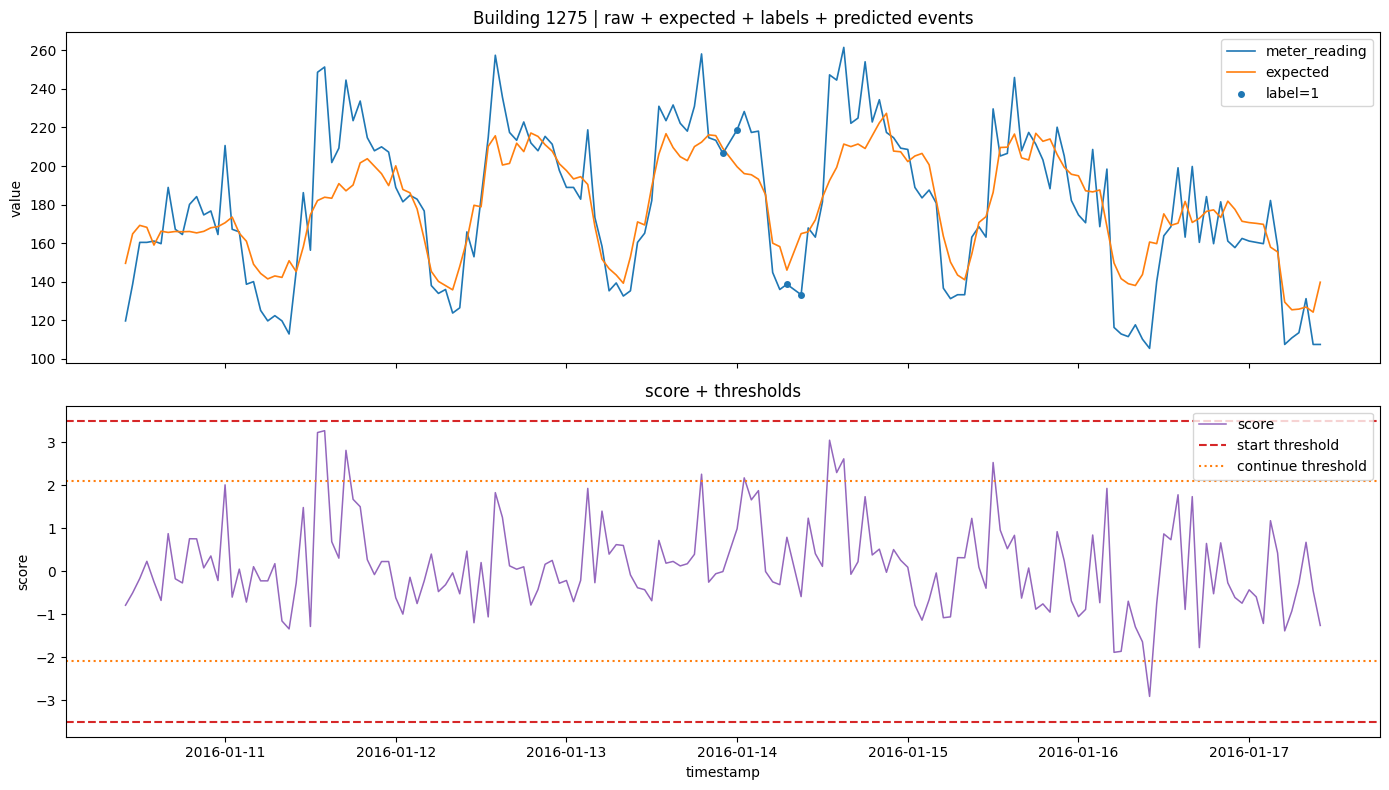

[11/20] building 693


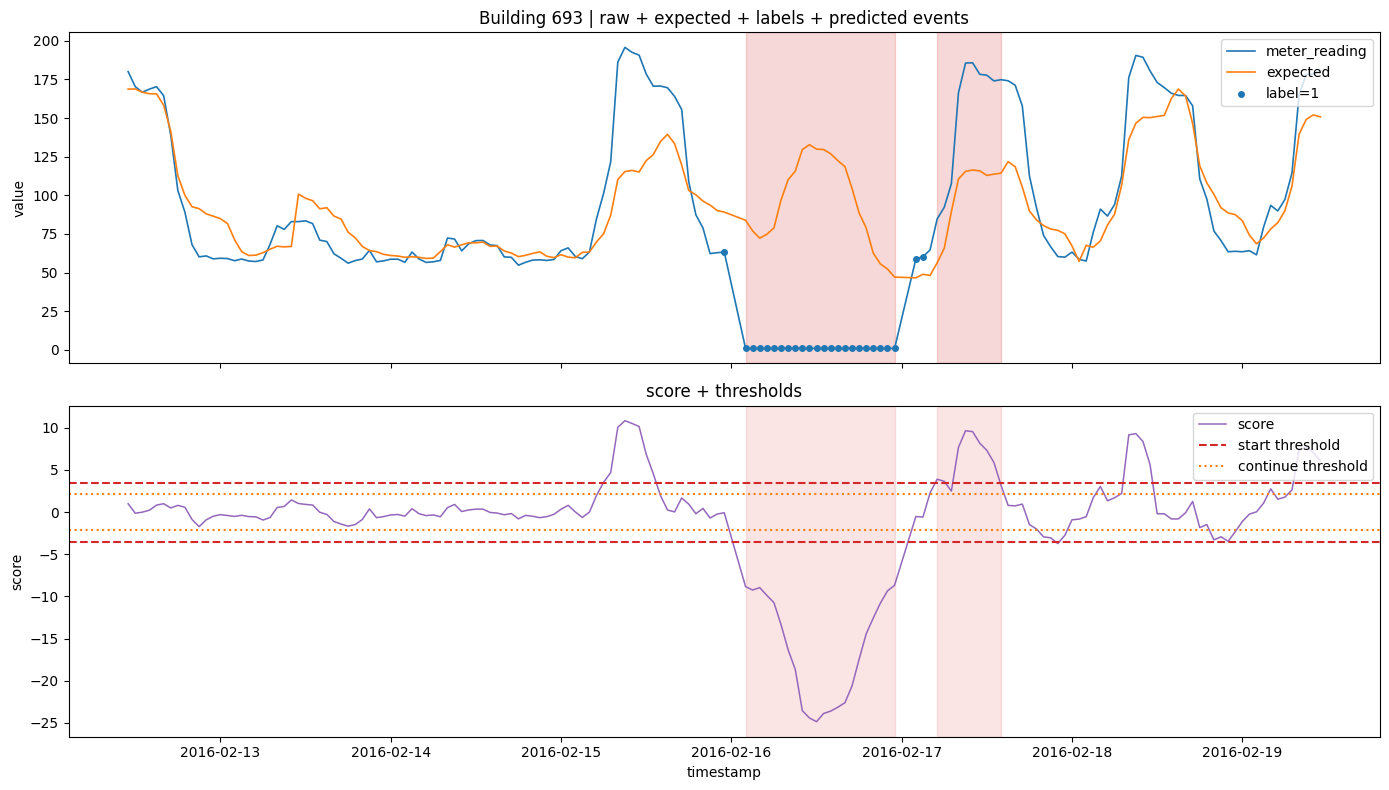

[12/20] building 1001


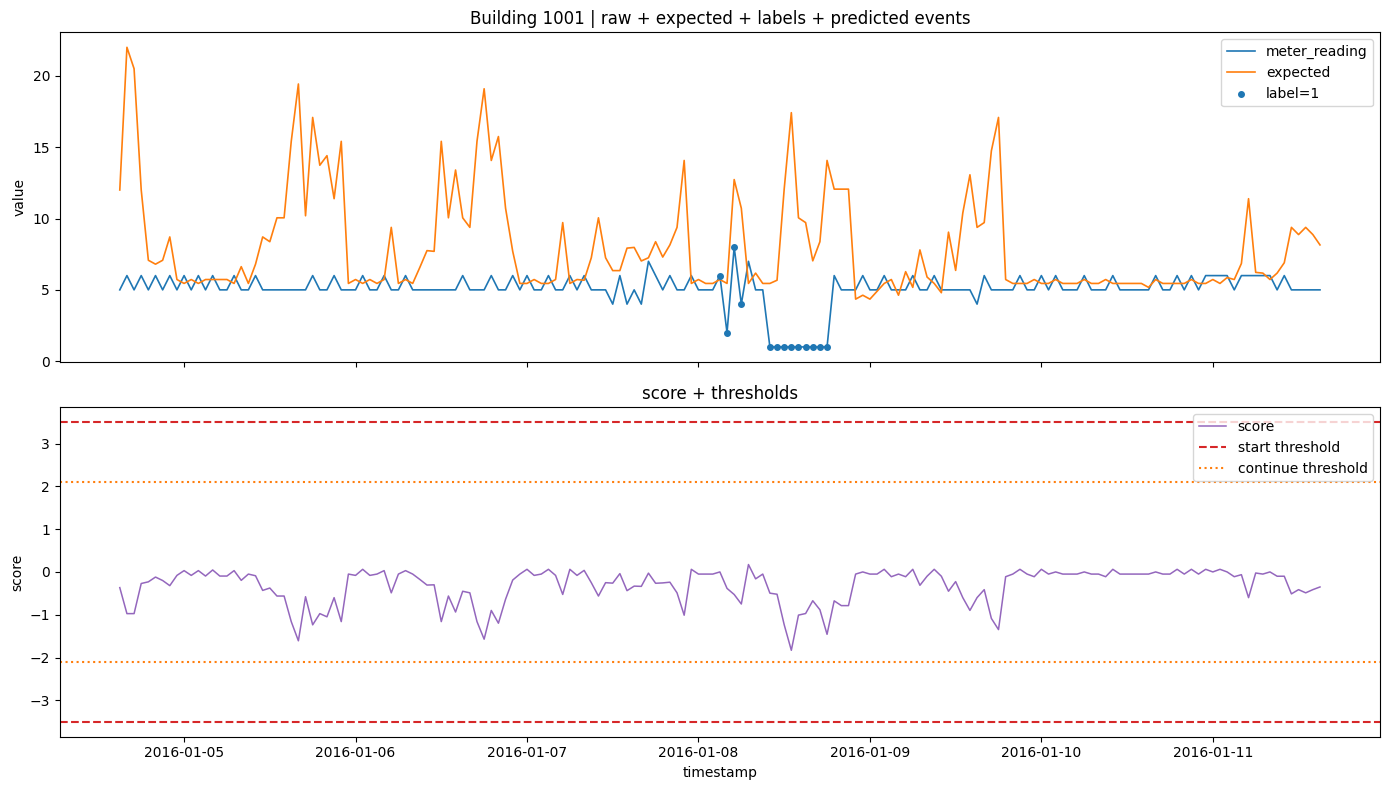

[13/20] building 290


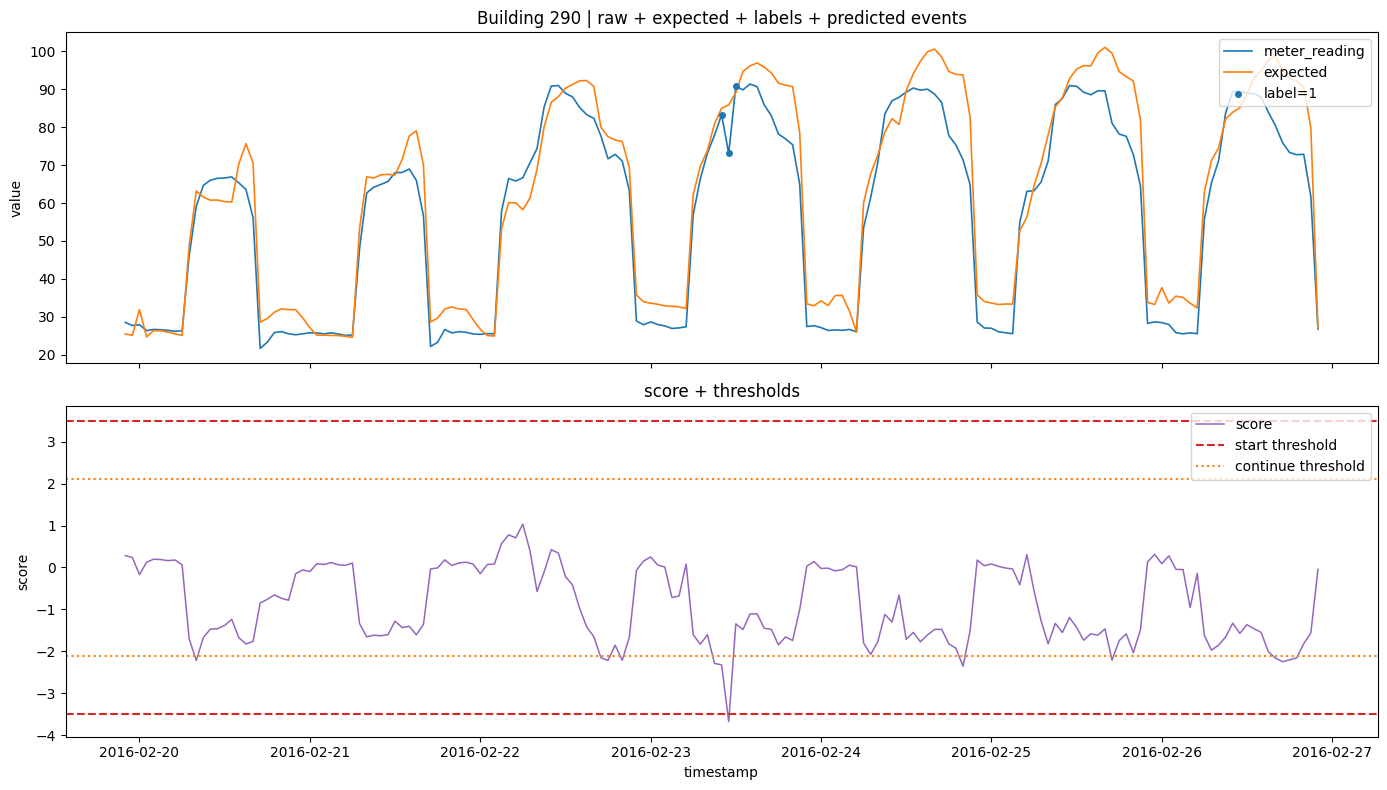

[14/20] building 159


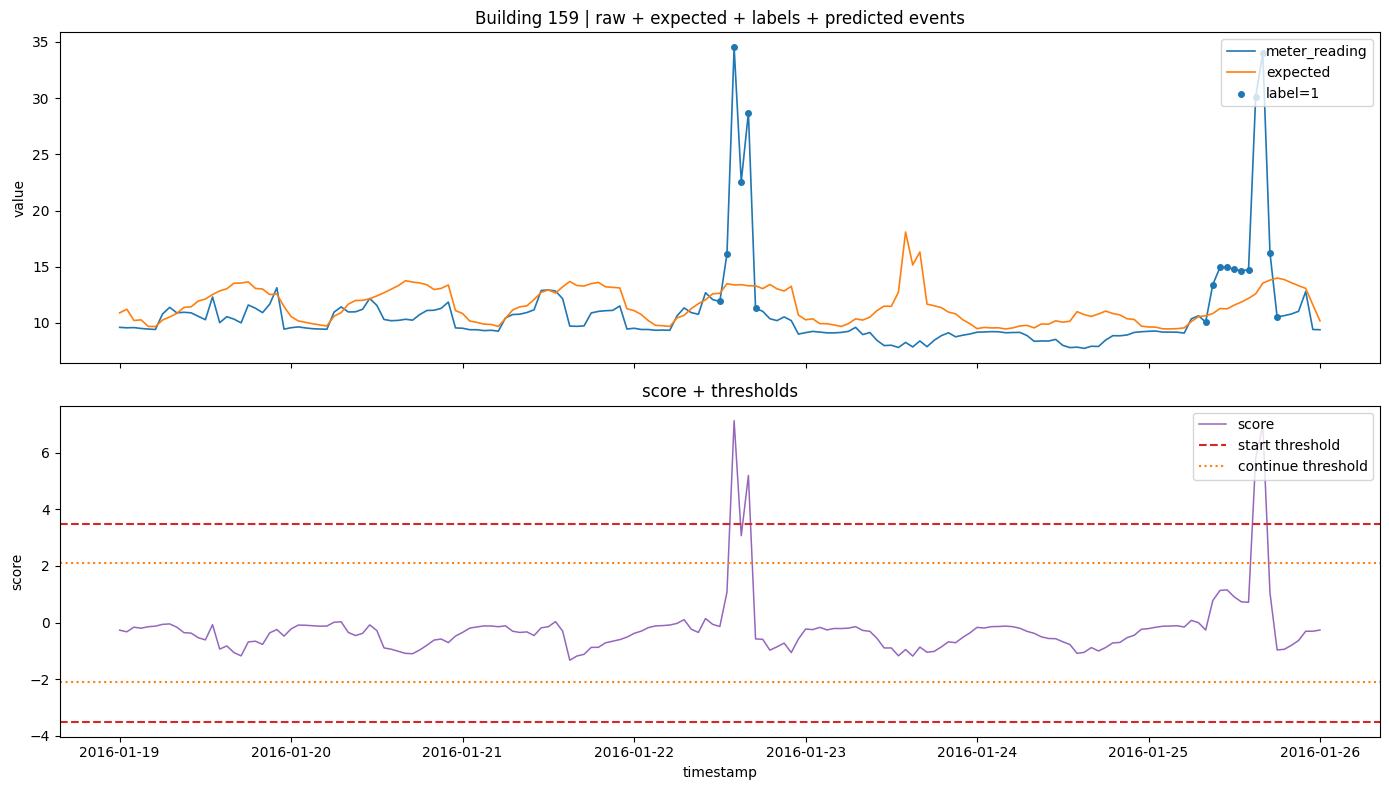

[15/20] building 108


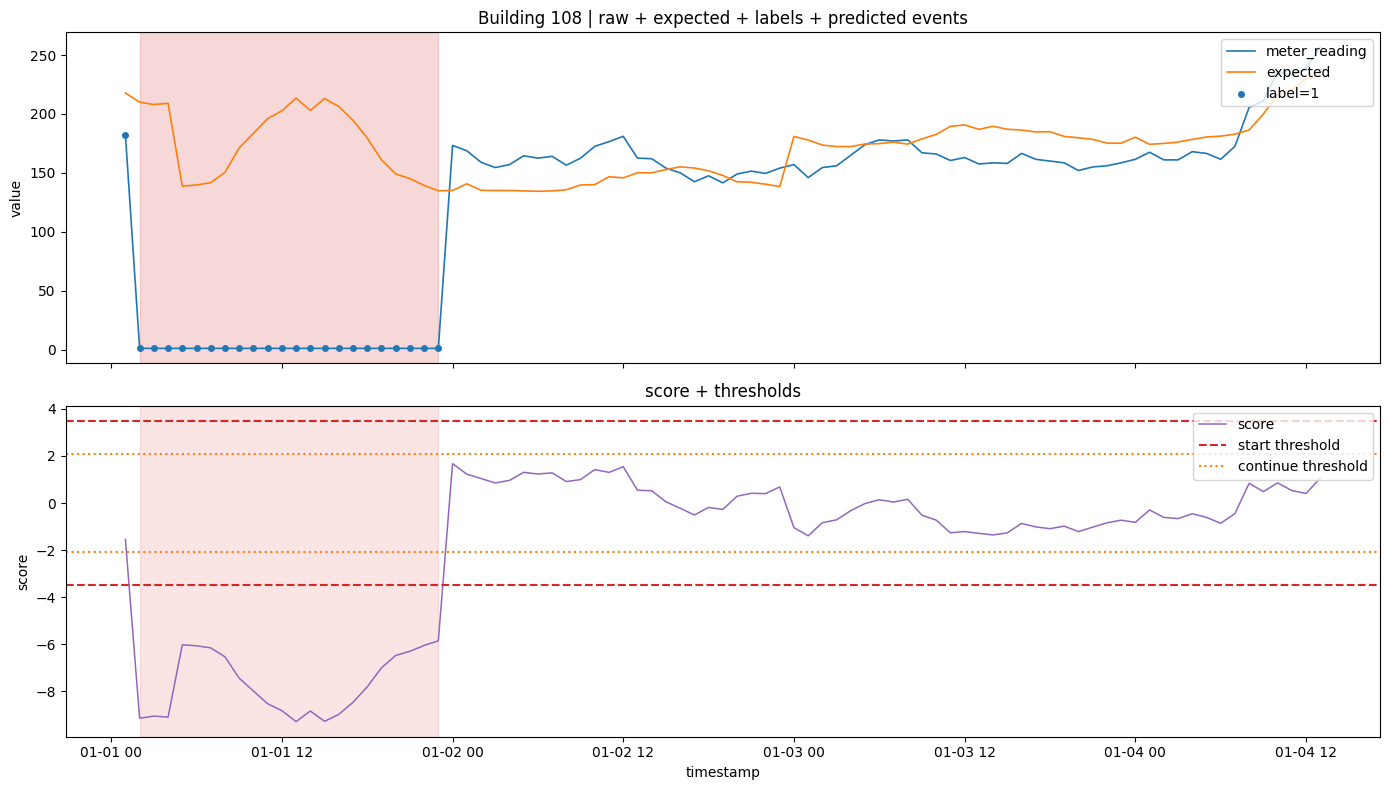

[16/20] building 1302


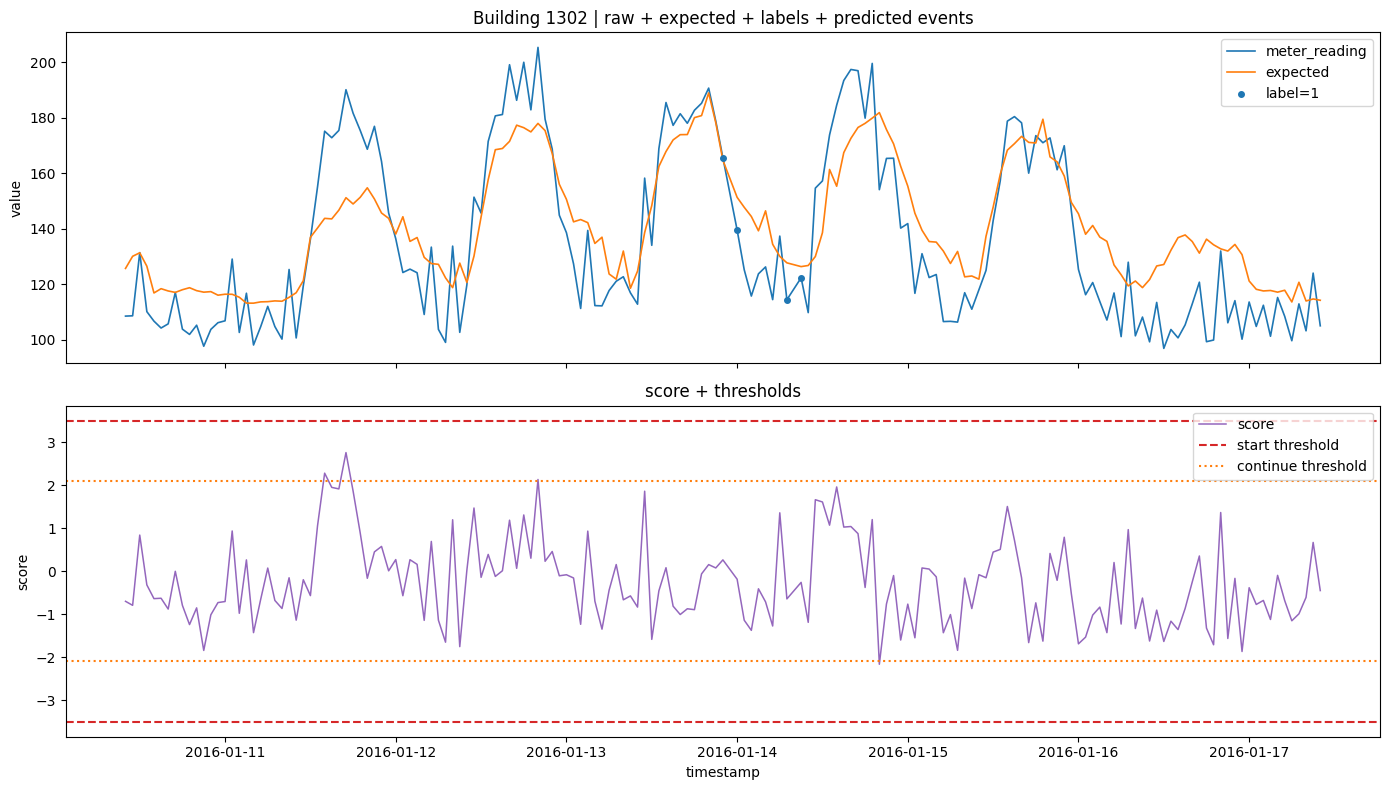

[17/20] building 936


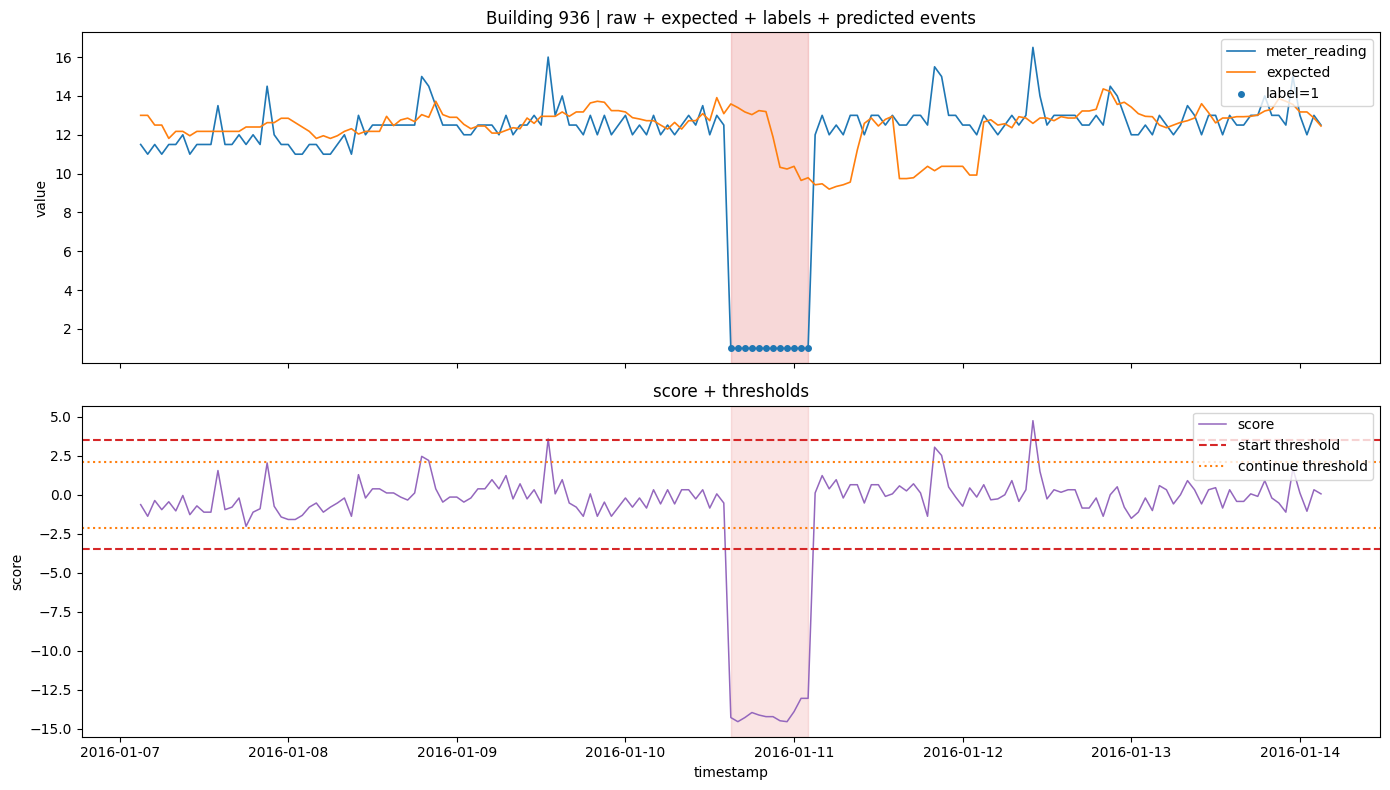

[18/20] building 1296


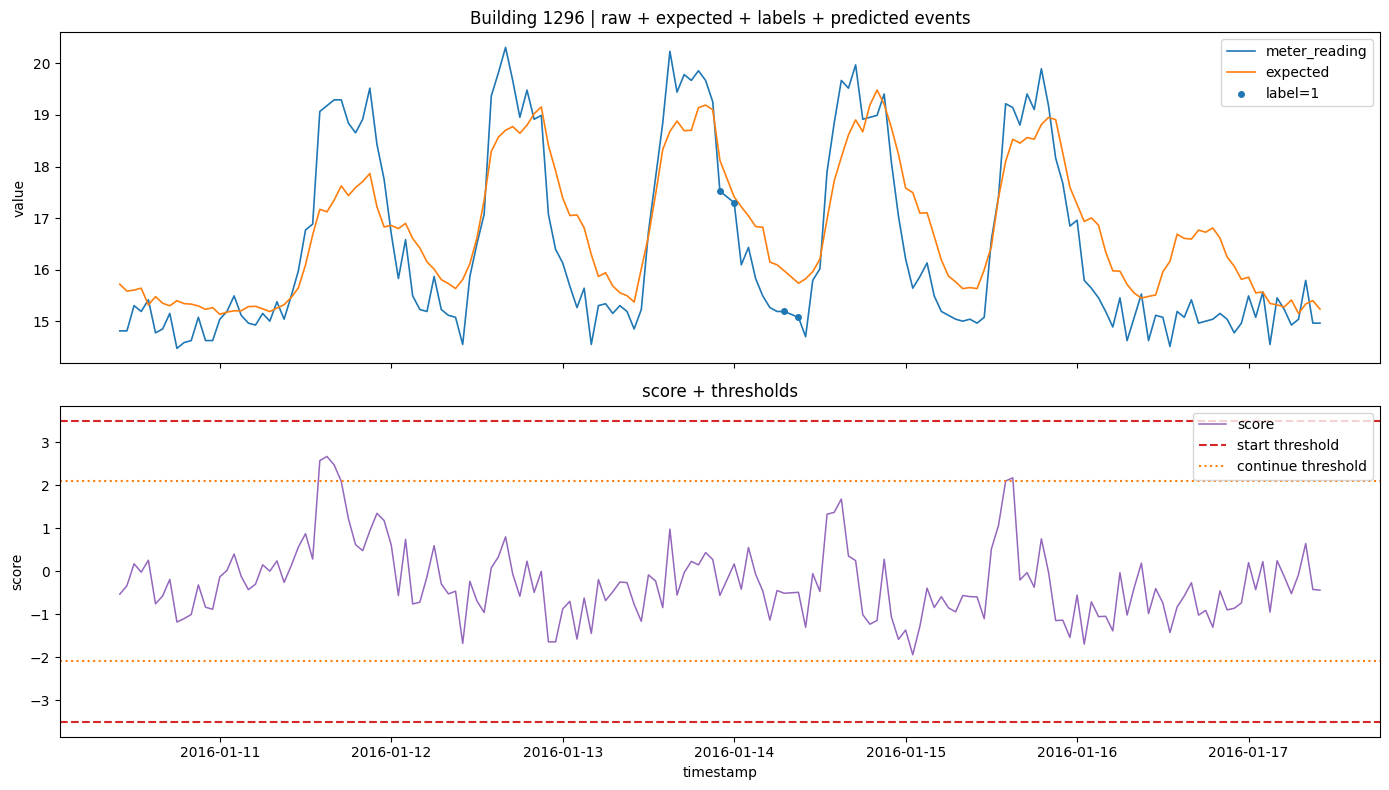

[19/20] building 732


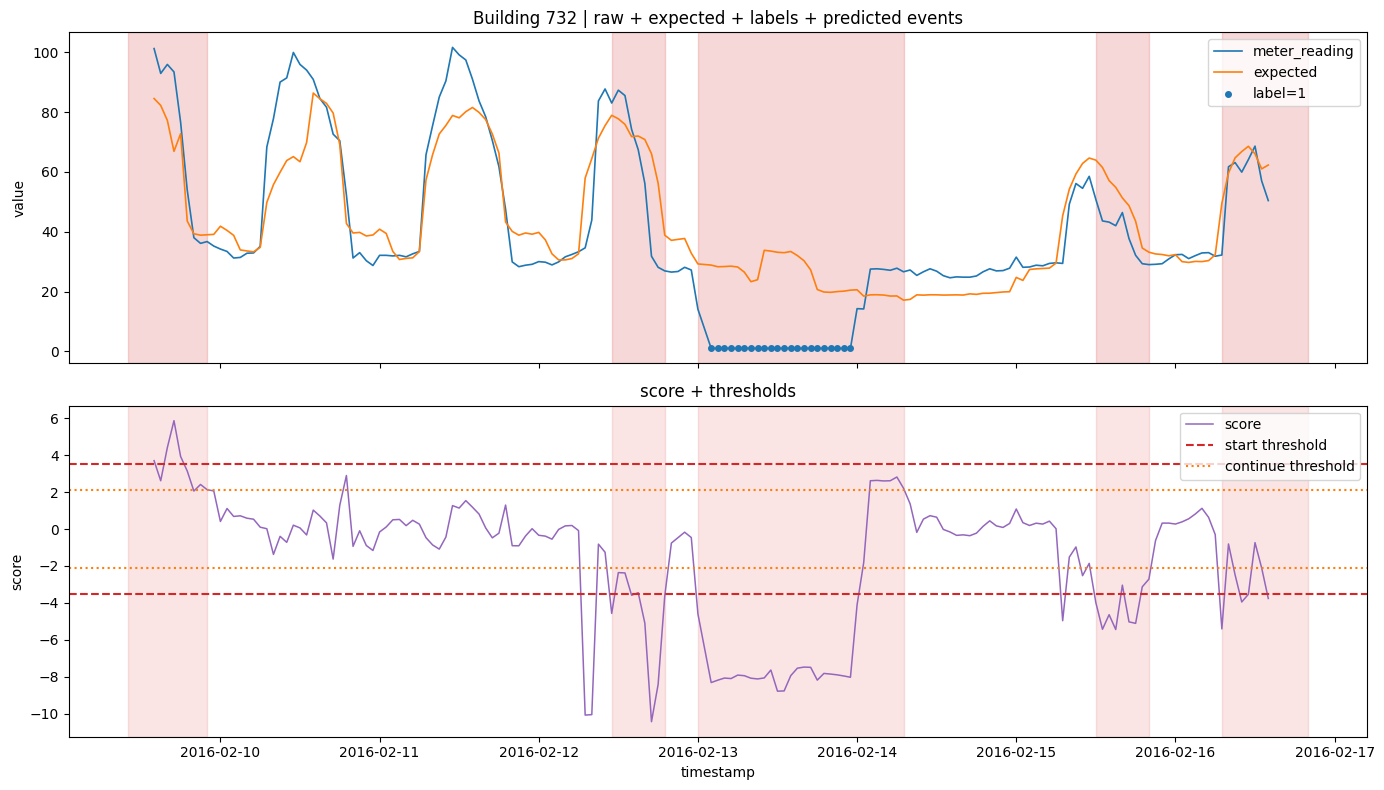

[20/20] building 1068


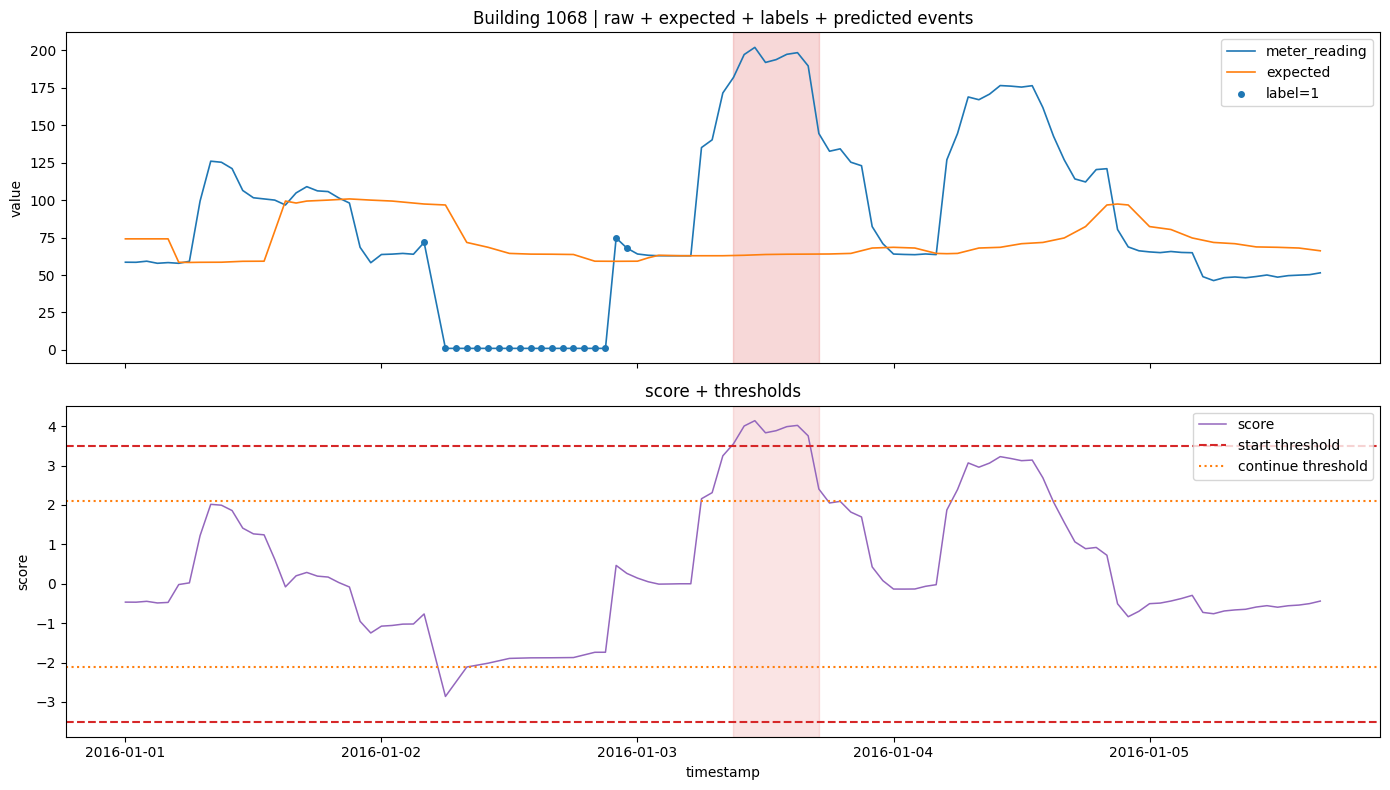

In [ ]:
# Batch plot controls
SELECTION_MODE = 'most_anomalies'  # 'most_anomalies' | 'most_events' | 'random'
N_BUILDINGS = 20
WINDOW_HOURS = 168
SAVE_PLOTS = False
PLOT_DIR = Path('../out/building_plots')
RANDOM_SEED = 42

if SELECTION_MODE == 'most_anomalies':
    ranking = (
        df.groupby('building_id')['anomaly']
        .sum()
        .sort_values(ascending=False)
    )
elif SELECTION_MODE == 'most_events':
    ranking = (
        pred_evt.groupby('entity_id')
        .size()
        .sort_values(ascending=False)
    )
elif SELECTION_MODE == 'random':
    ids = sorted(df['building_id'].unique())
    ranking = pd.Series(1, index=ids)
    ranking = ranking.sample(frac=1.0, random_state=RANDOM_SEED)
else:
    raise ValueError('SELECTION_MODE must be one of: most_anomalies, most_events, random')

sample_buildings = [int(x) for x in ranking.head(N_BUILDINGS).index.tolist()]
print(f'Selection mode: {SELECTION_MODE}')
print(f'Buildings to plot ({len(sample_buildings)}):', sample_buildings)

for i, bid in enumerate(sample_buildings, start=1):
    out_path = (PLOT_DIR / f'building_{bid}.png') if SAVE_PLOTS else None
    print(f'[{i}/{len(sample_buildings)}] building {bid}')
    plot_building_diagnostics(
        det,
        diag,
        pred_evt,
        building_id=bid,
        window_hours=WINDOW_HOURS,
        save_path=out_path,
        show=True,
    )

if SAVE_PLOTS:
    print('Saved plots to:', PLOT_DIR.resolve())


## B) Plot Score Distributions

For one building, compare score distribution under `anomaly=1` vs `anomaly=0`.
Heavy overlap means thresholding alone cannot separate classes well.


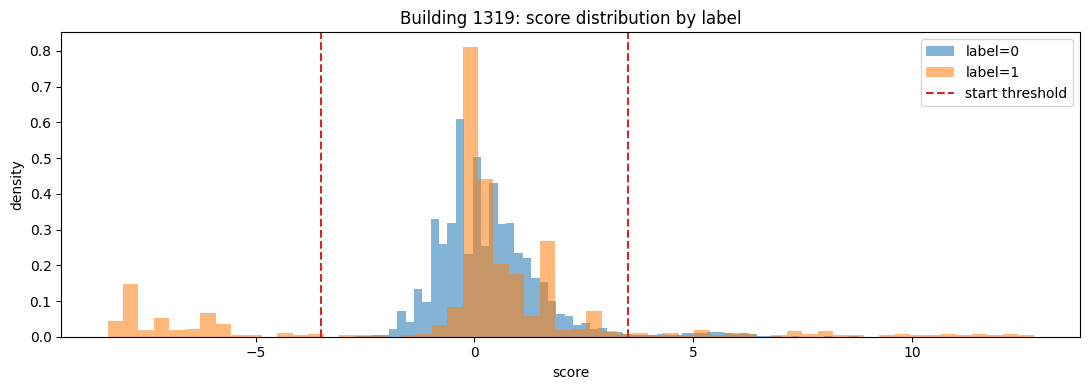

Focus building: 1319
routed detector: EnergyTimeSeriesDetector
score mean(label=0): 0.3483568524287645
score mean(label=1): -0.19621599837810444
n label=0: 6806 n label=1: 775


In [ ]:
focus_building = sample_buildings[0]
b = diag[diag["building_id"] == focus_building].copy()
b = b.dropna(subset=["score"])

s_anom = b.loc[b["anomaly"] == 1, "score"]
s_norm = b.loc[b["anomaly"] == 0, "score"]

active_detector = detector_for_building(int(focus_building))
thr_start, thr_end = _entity_thresholds(active_detector, focus_building)

plt.figure(figsize=(11, 4))
plt.hist(s_norm, bins=60, alpha=0.55, density=True, label="label=0")
plt.hist(s_anom, bins=60, alpha=0.55, density=True, label="label=1")
if active_detector.direction == "both":
    plt.axvline(thr_start, linestyle="--", color="tab:red", label="start threshold")
    plt.axvline(-thr_start, linestyle="--", color="tab:red")
elif active_detector.direction == "high":
    plt.axvline(thr_start, linestyle="--", color="tab:red", label="start threshold")
else:
    plt.axvline(-thr_start, linestyle="--", color="tab:red", label="start threshold")
plt.title(f"Building {focus_building}: score distribution by label")
plt.xlabel("score")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

print("Focus building:", focus_building)
print("routed detector:", active_detector.__class__.__name__)
print("score mean(label=0):", float(s_norm.mean()) if len(s_norm) else float("nan"))
print("score mean(label=1):", float(s_anom.mean()) if len(s_anom) else float("nan"))
print("n label=0:", len(s_norm), "n label=1:", len(s_anom))


## C) Count Anomaly Density Per Building

This checks how much anomaly prevalence varies by building.
Large spread can break a single global policy and stress quantile assumptions.


In [ ]:
density = (
    df.groupby('building_id')['anomaly']
    .agg(['mean', 'sum', 'count'])
    .rename(columns={'mean': 'anomaly_rate'})
    .sort_values('anomaly_rate', ascending=False)
)

print('Anomaly density summary (%):')
print((density['anomaly_rate'] * 100).describe().to_string())

print('\nTop 10 highest anomaly-rate buildings (%):')
display((density.head(10) * [100, 1, 1]).rename(columns={'anomaly_rate': 'anomaly_rate_%'}))

print('\nTop 10 lowest anomaly-rate buildings (%):')
display((density.tail(10) * [100, 1, 1]).rename(columns={'anomaly_rate': 'anomaly_rate_%'}))


Anomaly density summary (%):
count    200.000000
mean       2.322779
std        1.349192
min        0.899670
25%        1.324882
50%        1.989150
75%        2.924003
max       10.222926

Top 10 highest anomaly-rate buildings (%):


,anomaly_rate_%,sum,count
building_id,,,
1319,10.222926,775,7581
1258,8.254226,713,8638
144,7.320688,247,3374
439,6.474081,567,8758
693,6.126296,325,5305
247,5.706457,479,8394
141,5.670633,386,6807
1225,5.648408,463,8197
1226,5.485644,449,8185



Top 10 lowest anomaly-rate buildings (%):


,anomaly_rate_%,sum,count
building_id,,,
996,0.987913,85,8604
677,0.985109,86,8730
173,0.967999,85,8781
941,0.951828,82,8615
91,0.944969,51,5397
978,0.942189,81,8597
970,0.932483,79,8472
240,0.916905,80,8725
1143,0.910747,80,8784
